In [1]:
%gui qt
%matplotlib_svg
import numpy as np
import pylab as pl
from scipy import spatial

## 空间算法库-spatial

### 计算最近旁点

In [3]:
x = np.sort(np.random.rand(100))
idx = np.searchsorted(x, 0.5)
print((x[idx], x[idx - 1])) #距离0.5最近的数是这两个数中的一个

0.542258714465 0.492205345391


In [14]:
from scipy import spatial
np.random.seed(42)
N = 100
points = np.random.uniform(-1, 1, (N, 2))
kd = spatial.cKDTree(points)

targets = np.array([(0, 0), (0.5, 0.5), (-0.5, 0.5), (0.5, -0.5), (-0.5, -0.5)])
dist, idx = kd.query(targets, 3)
%C dist; idx

                   dist                         idx      
-----------------------------------------  --------------
[[ 0.15188266,  0.21919416,  0.27647793],  [[48, 73, 81],
 [ 0.09595807,  0.15745334,  0.22855398],   [37, 78, 43],
 [ 0.05009422,  0.17583445,  0.1807312 ],   [79, 22, 92],
 [ 0.11180181,  0.16618122,  0.18127473],   [35, 58,  6],
 [ 0.19015485,  0.19060739,  0.19361173]]   [83,  7, 42]]


In [5]:
r = 0.2
idx2 = kd.query_ball_point(targets, r)
idx2

array([[48], [37, 78], [79, 92, 22], [58, 35, 6], [7, 55, 83, 42]], dtype=object)

In [6]:
idx3 = kd.query_pairs(0.1) - kd.query_pairs(0.08)
%col 6 idx3

{(1, 46),     (3, 21),     (3, 82),     (3, 95),     (5, 16),     (9, 30),    
 (10, 87),    (11, 42),    (11, 97),    (18, 41),    (29, 74),    (32, 51),   
 (37, 78),    (39, 61),    (41, 61),    (50, 84),    (55, 83),    (73, 81)}   


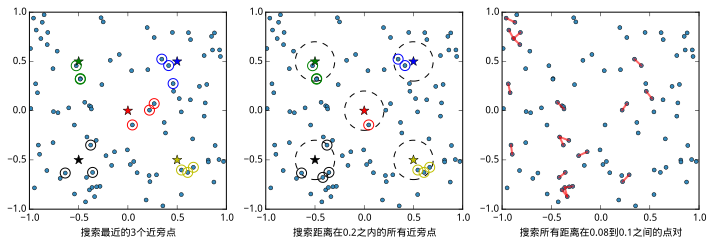

In [7]:
#%figonly=用cKDTree寻找近旁点
x, y = points.T
colors = "r", "b", "g", "y", "k"

fig, (ax1, ax2, ax3) = pl.subplots(1, 3, figsize=(12, 4))

for ax in ax1, ax2, ax3:
    ax.set_aspect("equal")
    ax.plot(x, y, "o", markersize=4)
    
for ax in ax1, ax2:
    for i in range(len(targets)):
        c = colors[i]
        tx, ty = targets[i]
        ax.plot([tx], [ty], "*", markersize=10, color=c)

for i in range(len(targets)):
    nx, ny = points[idx[i]].T
    ax1.plot(nx, ny, "o", markersize=10, markerfacecolor="None", 
             markeredgecolor=colors[i], markeredgewidth=1)
    
    nx, ny = points[idx2[i]].T
    ax2.plot(nx, ny, "o", markersize=10, markerfacecolor="None", 
             markeredgecolor=colors[i], markeredgewidth=1)
    
    ax2.add_artist(pl.Circle(targets[i], r, fill=None, linestyle="dashed"))
    
for pidx1, pidx2 in idx3:
    sx, sy = points[pidx1]
    ex, ey = points[pidx2]
    ax3.plot([sx, ex], [sy, ey], "r", linewidth=2, alpha=0.6)
    
ax1.set_xlabel("搜索最近的3个近旁点")
ax2.set_xlabel("搜索距离在0.2之内的所有近旁点")
ax3.set_xlabel("搜索所有距离在0.08到0.1之间的点对");

In [8]:
from scipy.spatial import distance
dist1 = distance.squareform(distance.pdist(points))
dist2 = distance.cdist(points, targets)
%C dist1.shape; dist2.shape

dist1.shape  dist2.shape
-----------  -----------
(100, 100)   (100, 5)   


In [9]:
print((dist[:, 0])) # cKDTree.query()返回的与targets最近的距离
print((np.min(dist2, axis=0)))

[ 0.15188266  0.09595807  0.05009422  0.11180181  0.19015485]
[ 0.15188266  0.09595807  0.05009422  0.11180181  0.19015485]


In [10]:
dist1[np.diag_indices(len(points))] = np.inf
nearest_pair = np.unravel_index(np.argmin(dist1), dist1.shape)
print((nearest_pair, dist1[nearest_pair]))

(22, 92) 0.00534621024816


In [11]:
dist, idx = kd.query(points, 2)
print((idx[np.argmin(dist[:, 1])], np.min(dist[:, 1])))

[22 92] 0.00534621024816


In [97]:
N = 1000000
start = np.random.uniform(0, 100, N)
span = np.random.uniform(0.01, 1, N)
span = np.clip(span, 2, 100)
end = start + span

In [80]:
def naive_count_at(start, end, time):
    mask = (start < time) & (end > time)
    return np.sum(mask)

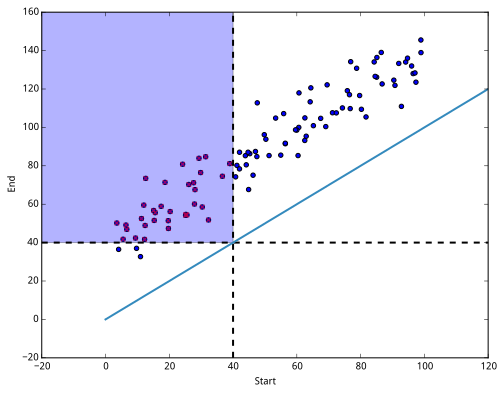

In [85]:
#%figonly=使用二维K-d树搜索指定区间的在线用户
def _():
    N = 100
    start = np.random.uniform(0, 100, N)
    span = np.random.normal(40, 10, N)
    span = np.clip(span, 2, 100)
    end = start + span

    time = 40
    
    fig, ax = pl.subplots(figsize=(8, 6))
    ax.scatter(start, end)
    mask = (start < time) & (end > time)
    start2, end2 = start[mask], end[mask]
    ax.scatter(start2, end2, marker="x", color="red")
    rect = pl.Rectangle((-20, 40), 60, 120, alpha=0.3)
    ax.add_patch(rect)
    ax.axhline(time, color="k", ls="--")
    ax.axvline(time, color="k", ls="--")
    ax.set_xlabel("Start")
    ax.set_ylabel("End")
    ax.set_xlim(-20, 120)
    ax.set_ylim(-20, 160)
    ax.plot([0, 120], [0, 120])

_()

In [87]:
class KdSearch(object):
    def __init__(self, start, end, leafsize=10):
        self.tree = spatial.cKDTree(np.c_[start, end], leafsize=leafsize)
        self.max_time = np.max(end)
      
    def count_at(self, time):
        max_time = self.max_time
        to_search = spatial.cKDTree([[time - max_time, time + max_time]])
        return self.tree.count_neighbors(to_search, max_time, p=np.inf)
    
naive_count_at(start, end, 40) == KdSearch(start, end).count_at(40)

True

> **QUESTION**

> 请读者研究点数`N`和`leafsize`参数与创建K-d树和搜索时间之间的关系。

In [100]:
%time ks = KdSearch(start, end, leafsize=100)
%timeit naive_search(start, end, 40)
%timeit ks.count_at(40)

Wall time: 484 ms
100 loops, best of 3: 3.85 ms per loop
1000 loops, best of 3: 221 µs per loop


### 凸包

In [12]:
np.random.seed(42)
points2d = np.random.rand(10, 2)
ch2d = spatial.ConvexHull(points2d)
%C ch2d.simplices; ch2d.vertices

ch2d.simplices   ch2d.vertices 
--------------  ---------------
[[2, 5],        [5, 2, 6, 1, 0]
 [2, 6],                       
 [0, 5],                       
 [1, 6],                       
 [1, 0]]                       


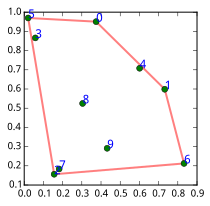

In [13]:
#%fig=二维平面上的凸包
poly = pl.Polygon(points2d[ch2d.vertices], fill=None, lw=2, color="r", alpha=0.5)
ax = pl.subplot(aspect="equal")
pl.plot(points2d[:, 0], points2d[:, 1], "go")
for i, pos in enumerate(points2d):
    pl.text(pos[0], pos[1], str(i), color="blue")
ax.add_artist(poly);

In [2]:
np.random.seed(42)
points3d = np.random.rand(40, 3)
ch3d = spatial.ConvexHull(points3d)
ch3d.simplices.shape

(38, 3)

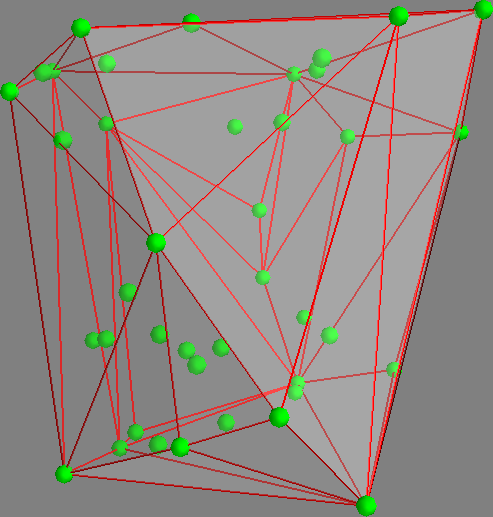

In [5]:
#%fig=三维空间中的凸包
from scpy2 import vtk_convexhull, vtk_scene, vtk_scene_to_array
actors = vtk_convexhull(ch3d)
scene = vtk_scene(actors, viewangle=22)
%array_image vtk_scene_to_array(scene)
scene.close()

In [25]:
%gui qt
from scpy2 import ivtk_scene
ivtk_scene(actors)

### 沃罗诺伊图

In [15]:
points2d = np.array([[0.2, 0.1], [0.5, 0.5], [0.8, 0.1],
                     [0.5, 0.8], [0.3, 0.6], [0.7, 0.6], [0.5, 0.35]])
vo = spatial.Voronoi(points2d)

%C vo.vertices; vo.regions; vo.ridge_vertices

    vo.vertices           vo.regions     vo.ridge_vertices
--------------------  -----------------  -----------------
[[ 0.5   ,  0.045 ],  [[-1, 0, 1],       [[-1, 0],        
 [ 0.245 ,  0.351 ],   [-1, 0, 2],        [0, 1],         
 [ 0.755 ,  0.351 ],   [],                [-1, 1],        
 [ 0.3375,  0.425 ],   [6, 4, 3, 5],      [0, 2],         
 [ 0.6625,  0.425 ],   [5, -1, 1, 3],     [-1, 2],        
 [ 0.45  ,  0.65  ],   [4, 2, 0, 1, 3],   [3, 5],         
 [ 0.55  ,  0.65  ]]   [6, -1, 2, 4],     [3, 4],         
                       [6, -1, 5]]        [4, 6],         
                                          [5, 6],         
                                          [1, 3],         
                                          [-1, 5],        
                                          [2, 4],         
                                          [-1, 6]]        


In [17]:
bound = np.array([[-100, -100], [-100,  100], 
                  [ 100,  100], [ 100, -100]])
vo2 = spatial.Voronoi(np.vstack((points2d, bound)))

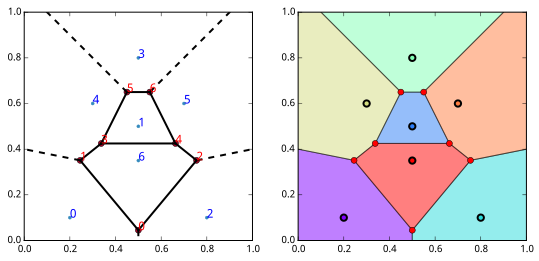

In [18]:
#%figonly=沃罗诺伊图将空间分割为多个区域
fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(9, 4.5))
ax1.set_aspect("equal")
ax2.set_aspect("equal")
spatial.voronoi_plot_2d(vo, ax=ax1)
for i, v in enumerate(vo.vertices):
    ax1.text(v[0], v[1], str(i), color="red")
    
for i, p in enumerate(points2d):
    ax1.text(p[0], p[1], str(i), color="blue")

n = len(points2d)
color = pl.cm.rainbow(np.linspace(0, 1, n))
for i in range(n):
    idx = vo2.point_region[i]
    region = vo2.regions[idx]
    poly = pl.Polygon(vo2.vertices[region], facecolor=color[i], alpha=0.5, zorder=0)
    ax2.add_artist(poly)
ax2.scatter(points2d[:, 0], points2d[:, 1], s=40, c=color, linewidths=2, edgecolors="k")
ax2.plot(vo2.vertices[:, 0], vo2.vertices[:, 1], "ro", ms=6)

for ax in ax1, ax2:
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

In [19]:
print((vo.point_region))
print((vo.regions[6]))

[0 3 1 7 4 6 5]
[6, -1, 2, 4]


r =  0.174278456762 , center =  [ 0.46973363  0.59356531]


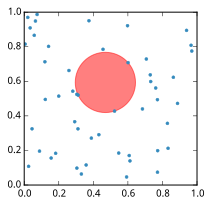

In [2]:
#%fig=使用沃罗诺伊图计算最大空圆
from collections import defaultdict

n = 50
np.random.seed(42)
points2d = np.random.rand(n, 2)
vo = spatial.Voronoi(points2d)
ch = spatial.ConvexHull(points2d)
poly = pl.Polygon(points2d[ch.vertices]) #❶
vs = vo.vertices
convexhull_mask = [poly.contains_point(p, radius=0) for p in vs] #❷

vertice_point_map = defaultdict(list) #❸
for index_point, index_region in enumerate(vo.point_region):
    region = vo.regions[index_region]
    if -1 in region: continue
    for index_vertice in region:
        if convexhull_mask[index_vertice]:
            vertice_point_map[index_vertice].append(index_point)

def dist(p1, p2):
    return ((p1-p2)**2).sum()**0.5

max_cicle = max((dist(points2d[pidxs[0]], vs[vidx]), vs[vidx]) #❹
                for vidx, pidxs in list(vertice_point_map.items()))
r, center = max_cicle
print(("r = ", r, ", center = ", center))
#%hide
ax = pl.subplot(111, aspect="equal")
ax.plot(points2d[:, 0], points2d[:, 1], ".")

c = pl.Circle(center, r, fill=True, color="red", alpha=0.5)
ax.add_artist(c);

### 德劳内三角化

In [23]:
x = np.array([46.445, 263.251, 174.176, 280.899, 280.899, 
              189.358, 135.521, 29.638, 101.907, 226.665])
y = np.array([287.865, 250.891, 287.865, 160.975, 54.252,
              160.975, 232.404, 179.187, 35.765, 71.361])
points2d = np.c_[x, y]
dy = spatial.Delaunay(points2d)
vo = spatial.Voronoi(points2d) 

%C dy.simplices; vo.vertices

dy.simplices            vo.vertices           
------------  --------------------------------
[[8, 5, 7],   [[ 104.58977484,  127.03566055],
 [1, 5, 3],    [ 235.1285    ,  198.68143374],
 [5, 6, 7],    [ 107.83960707,  155.53682482],
 [6, 0, 7],    [  71.22104881,  228.39479887],
 [0, 6, 2],    [ 110.3105    ,  291.17642838],
 [6, 1, 2],    [ 201.40695449,  227.68436282],
 [1, 6, 5],    [ 201.61895891,  226.21958623],
 [9, 5, 8],    [ 152.96231864,   93.25060083],
 [4, 9, 8],    [ 205.40381294,  -90.5480267 ],
 [5, 9, 3],    [ 235.1285    ,  127.45701644],
 [9, 4, 3]]    [ 267.91709907,  107.6135    ]]


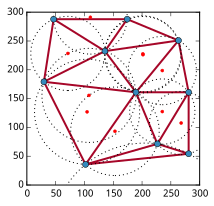

In [24]:
#%fig=德劳内三角形的外接圆与圆心
cx, cy = vo.vertices.T

ax = pl.subplot(aspect="equal")
spatial.delaunay_plot_2d(dy, ax=ax)
ax.plot(cx, cy, "r.")
for i, (cx, cy) in enumerate(vo.vertices):
    px, py = points2d[dy.simplices[i, 0]]
    radius = np.hypot(cx - px, cy - py)
    circle = pl.Circle((cx, cy), radius, fill=False, ls="dotted")
    ax.add_artist(circle)
ax.set_xlim(0, 300)
ax.set_ylim(0, 300);